In [1]:

import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
f(3.0)

20.0

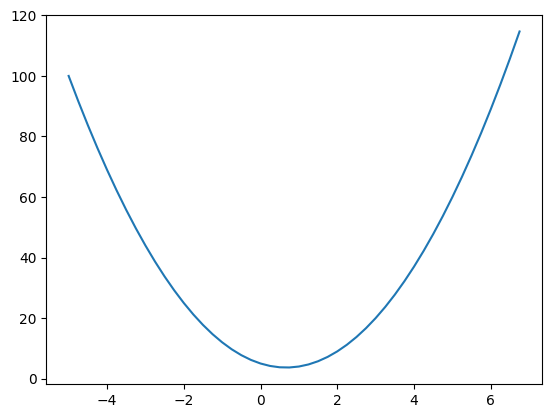

In [7]:
xs = np.arange(-5,7,.25)
ys = f(xs)
plt.plot(xs, ys)

In [8]:
h = 0.0001
x = 3
(f(x+h)-f(x))/h
# this is for finding the derivative 

14.000300000063248

In [9]:
h = 0.001
a = 2.0
b = -3.0
c = 10

d1 = a*b +c
a += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.997
slope -3.0000000000001137


In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build (v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label= "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:

            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)

    return dot


In [11]:
class value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance (other, value) else value(other)
        out = value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other


    def __neg__(self):
        return self*-1

    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance (other, value) else value(other)
        out = value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out 

    
    def __rmul__(self, other):
        return self*other

    
    def __truediv__(self, other):
        return self * other**-1

    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other*self.data**(other-1)*out.grad
        out._backward = _backward
        return out 


    
    def exp_(self):
        x = self.data
        out = value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        
        return out

    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


# examples
a = value(2.0, label='a')
b = value(-3.0, label='b')
c = value(10, label='c')
e = a*b
e.label = 'e'
d= e + c
d.label = 'd'
f = value (-2.0, label='f')
L = d*f 
L.label = 'L'

In [12]:
a = value(2.0, label='a')
b = value(4.0, label= 'b')

a/b
# (a.exp())

value(data=0.5)

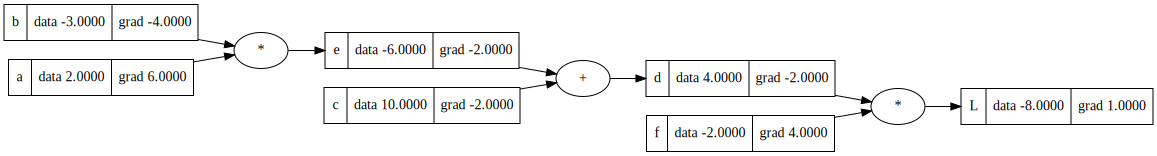

In [13]:
L.backward()
draw_dot(L)

In [14]:
# manually computing gradient for each nodes (this code block is not required as we can use the backward function to get the gradients)
#L.grad
L.grad = 1 

#children nodes of L
# d.grad = dL/dd = f
# f.grad = dL/df = d

d.grad = -2
f.grad = 4

# children nodes of d , d = e + c
# e.grad = dL/de = dL/dd * dd/de = d.grad * 1
# c.grad = dL/dc = dL/dd * dd/dc = d.grad * 1

e.grad = -2
c.grad = -2

# children nodes of e 
# a.grad = dL/da = dL/de*de/da = e.grad * b
# b.grad = dL/db = dL/de*de/db = e.grad * a
a.grad = 6
b.grad = -4

In [15]:
x1 = value(2.0, label='x1')
x2 = value(0, label='x2')


w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
b = value(6.881373587 , label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label='n'

# writing tanh manually 
e = (2*n).exp_()
o = (e-1)/(e+1)
# o = n.tanh()

o.label='o'



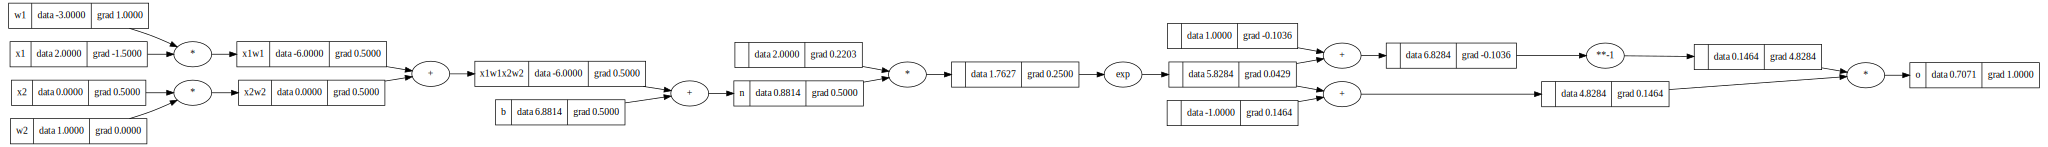

In [16]:
o.backward()
draw_dot(o)


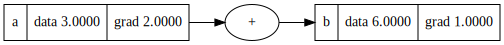

In [17]:
a = value(3.0, label='a')
b = a+a; b.label = 'b'
b.backward()
draw_dot(b)

In [18]:
# pytorch implementation to verify our micrograd_
import torch

In [19]:
x1 = torch.tensor([2.0]).double();  x1.requires_grad = True
x2 = torch.tensor([0.0]).double();  x2.requires_grad = True
w1 = torch.tensor([-3.0]).double();  w1.requires_grad = True
w2 = torch.tensor([1.0]).double();  w2.requires_grad = True
b = torch.tensor([6.881373587]).double();  b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----------------------')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
-----------------------
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [20]:
import random 

class Neuron:

    def __init__(self, nin):
        self.w = [value(random.uniform(-1,1), label =  f'w{nin}{i}') for i in range(nin)]
        self.b = value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range (nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]




In [21]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

value(data=0.45753291794647144)

In [22]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1,0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1,0, -1.0, 1.0]

In [23]:

for k in range (200):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout- ygt)**2 for ygt, yout in zip(ys, ypred))
    # print(loss)


    for p in n.parameters():
        p.grad = 0
        
    # backward pass
    loss.backward()

    # update 
    for p in n.parameters():
        p.data += -0.01*p.grad
    

    print(k+1, loss.data)

1 4.382938673867963
2 3.7920291503453445
3 3.3056258873720497
4 2.94189725921329
5 2.682687769133189
6 2.49817339338659
7 2.3625807031762722
8 2.257989379339361
9 2.173008427772107
10 2.1006312822754136
11 2.0365717066486164
12 1.978186084790437
13 1.9238188669779932
14 1.8724132989311633
15 1.823280467653203
16 1.775961444651244
17 1.7301441832124425
18 1.6856128341412635
19 1.6422164308166443
20 1.599849253465698
21 1.5584382886367125
22 1.5179350166751036
23 1.478309835754737
24 1.4395480777396767
25 1.4016469674370842
26 1.3646131254608023
27 1.3284603753291275
28 1.2932077217789764
29 1.2588774391204987
30 1.2254932567774985
31 1.1930786601314196
32 1.1616553420498357
33 1.1312418465548293
34 1.1018524431931769
35 1.0734962611124281
36 1.046176698077592
37 1.0198911041434902
38 0.9946307246621471
39 0.97038087452912
40 0.9471213062222807
41 0.924826728771876
42 0.9034674332434862
43 0.8830099820909322
44 0.8634179240497867
45 0.8446525022022151
46 0.8266733296003187
47 0.809439013

In [24]:
ypred = [n(x) for x in xs]
print(ypred)

[value(data=0.8302480890355203), value(data=-0.9794477315595184), value(data=0.0191153099615987), value(data=-0.8881690990791653)]


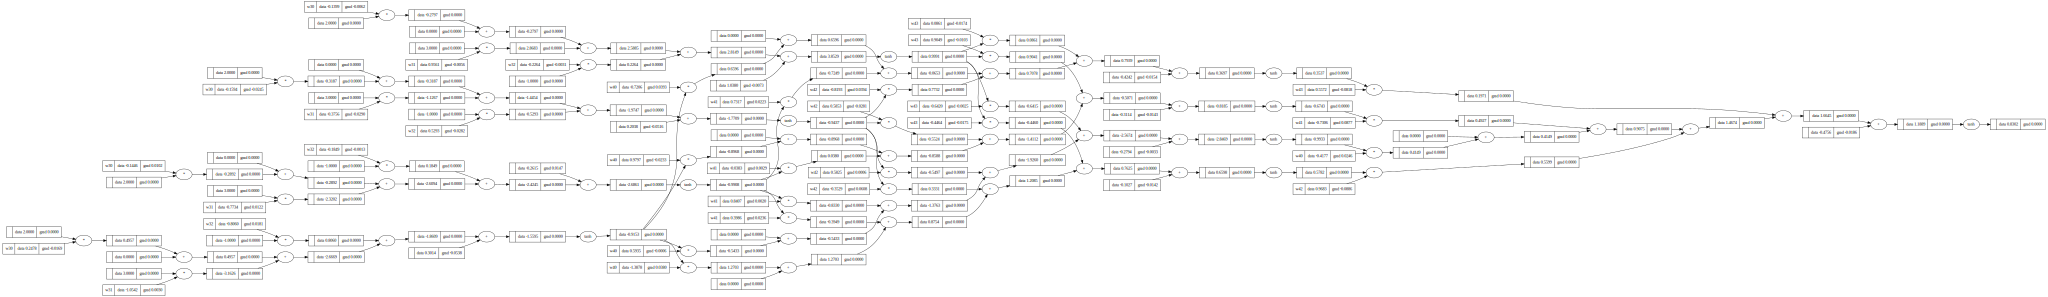

In [26]:
draw_dot(n(x))